# PREPROCESSING DATA

Importing libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
import tensorflow as tf

We create the variable X containing all the images of cars by resizing them to 200 * 200.

In [2]:
IMAGE_SIZE =200

In [3]:
img_dir = "vehicledetection/train/images"          #Directory of all images
data_path = os.path.join(img_dir,'*g')    
files = glob.glob(data_path)
files.sort()                                      #sorting the images to match them to the annotations 
X=[]
for f1 in files:
    img = cv2.imread(f1)                          #resizing images and storing them in X
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

Created a variable y containing all annotations. Before that, I  have to resize the annotations so that it fits the new size of the images (200*200). I create a function resizeannotation for that.

The annotation file 231 was empty so it needed to be deleted


In [4]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        try:
            xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        except ZeroDivisionError:
            xmin= int(dim.xpath("xmin")[0].text)/1
        try:    
            ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        except ZeroDivisionError:
            ymin= int(dim.xpath("ymin")[0].text)/1
        try:
            xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        except ZeroDivisionError:
            xmax= int(dim.xpath("xmax")[0].text)/1
        try:
            ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
        except ZeroDivisionError:
            ymax= int(dim.xpath("ymax")[0].text)/1
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [5]:
path = 'vehicledetection/train/annotation'
text_files = ['vehicledetection/train/annotation/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [6]:
resizeannotation("vehicledetection/train/annotation/01.xml")

[75, 63, 68, 56]

In [7]:
y[0] 

[75, 63, 68, 56]

In [8]:
np.array(X).shape

(3002, 200, 200, 3)

In [9]:
np.array(y).shape

(3002, 4)

Displaying the first eighteen images of the dataset 

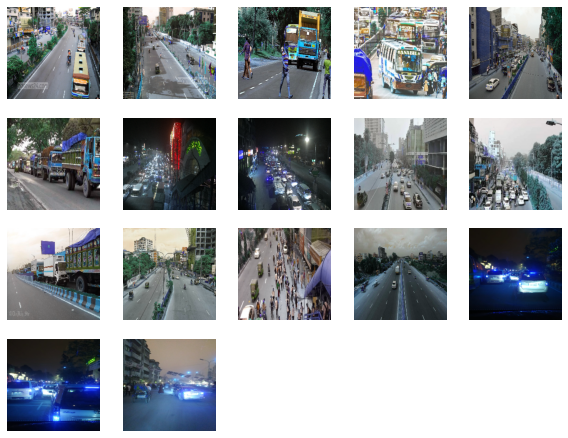

In [10]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

Drawing rectangle containing the vehicle using the OpenCV library

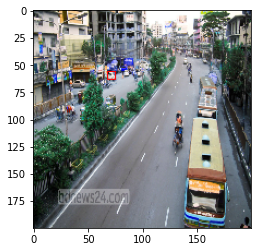

In [11]:
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(255, 0, 0))
plt.imshow(image)
plt.show()


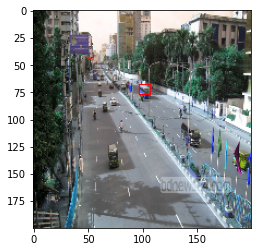

In [12]:
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(255, 0, 0))
plt.imshow(image)
plt.show()

Preparing the data for the CNN 

In [13]:
X=np.array(X)
y=np.array(y)

In [14]:
X = X / 255
y = y / 255

Spliting dataset in two parts training and testing set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Convolutionnal Neural Network

In [16]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

from tensorflow.keras import regularizers

In [17]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128,kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.001) ,activation="relu"))
model.add(Dense(4,kernel_regularizer=regularizers.l2(0.001) ,activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,086,788
Trainable params: 2,372,100
Non

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [19]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=25, verbose=1)

Epoch 1/50
109/109 [==============================] - 40s 265ms/step - loss: 0.1277 - accuracy: 0.5579 - val_loss: 0.0669 - val_accuracy: 0.5515
Epoch 2/50
109/109 [==============================] - 28s 253ms/step - loss: 0.0585 - accuracy: 0.6150 - val_loss: 0.0482 - val_accuracy: 0.6445
Epoch 3/50
109/109 [==============================] - 28s 254ms/step - loss: 0.0488 - accuracy: 0.6453 - val_loss: 0.0537 - val_accuracy: 0.5814
Epoch 4/50
109/109 [==============================] - 28s 254ms/step - loss: 0.0454 - accuracy: 0.6272 - val_loss: 0.0450 - val_accuracy: 0.6545
Epoch 5/50
109/109 [==============================] - 28s 255ms/step - loss: 0.0423 - accuracy: 0.6731 - val_loss: 0.0369 - val_accuracy: 0.6545
Epoch 6/50
109/109 [==============================] - 28s 256ms/step - loss: 0.0406 - accuracy: 0.6742 - val_loss: 0.0381 - val_accuracy: 0.6246
Epoch 7/50
109/109 [==============================] - 28s 259ms/step - loss: 0.0386 - accuracy: 0.6838 - val_loss: 0.0358 - val_ac

In [20]:
with tf.device("cpu:0"):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Score : %.2f%%" % (scores[1]*100))    

Score : 66.45%


In [21]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

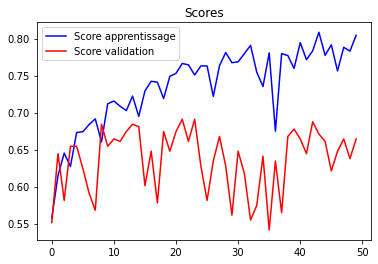

In [22]:
plot_scores(train)